# Project: Wrangling and Analyze Data

## Importing packages for Analysis

In [1]:
import numpy as np
import pandas as pd
import requests
import json
import re
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import tweepy as tw

## Data Gathering

1. Upload the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [3]:
dog_arch = pd.read_csv(r'C:\Users\gyabaah.poku\OneDrive - Vodafone Group\VDF Project\PY\Udacity Data Science\Project 2\twitter-archive-enhanced.csv')

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [6]:
URL = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

In [7]:
response = requests.get(URL)

with open('image_predictions.tsv', 'wb') as file:
    file.write(response.content)

In [8]:
image_df = pd.read_csv('image-predictions.tsv', sep='\t')

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [9]:
auth = tw.OAuth1UserHandler(API_KEY, API_KEY_SECRET, ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tw.API(auth)

NameError: name 'API_KEY' is not defined

In [10]:
tweet_ids = [tweet_id for tweet_id in dog_arch['tweet_id']]

In [11]:
with open('tweet_json.txt', 'a') as txt_file:
    for tweet_id in tweet_ids:
        try:
            txt_file.write(json.dumps(api.get_status(tweet_id)._json))
            txt_file.write('\n')
        except Exception as e:
            continue

In [12]:
tweet = []

with open('tweet_json.txt','r') as file:
    for item in file:
        data = json.loads(item) #run the item to a python dictionary
        tweet.append(data)

In [13]:
tweet_df = pd.DataFrame(tweet, columns = ['id', 'retweet_count', 'favorite_count'])

## Assessing Data
In this section, I detect and document at least some quality and tidiness issues in our gathered using **both** visual assessment and programmatic assessement.



#### Assessing Data Programmartically

In [14]:
dog_arch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

#### Looking at the info on the archived data, we notice that there are some missing data for a numer of columns. One such column is the one holding data on 'expanded urls'. Since that column will not feature a lot in our analysis, we can remove it altogether during our cleaning process. 

In [17]:
dog_arch.retweeted_status_id


0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
2351   NaN
2352   NaN
2353   NaN
2354   NaN
2355   NaN
Name: in_reply_to_status_id, Length: 2356, dtype: float64

In [18]:
dog_arch.in_reply_to_status_id

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
2351   NaN
2352   NaN
2353   NaN
2354   NaN
2355   NaN
Name: in_reply_to_status_id, Length: 2356, dtype: float64

#### We can also notice that some rows of data have retweet status ids and in reply status ids. As status in the original project statement, there are a number of tweets with ratings which are not original but are either retweets or replies to original tweets. We can use these ids to identify these specific retweets and replies and delete them so they can not affect our ratings as 'double counts'

In [25]:
dog_arch.rating_denominator.max()

170

#### Checking the values for the rating denominator visually in Excel, we could see that there were multiple values greater than 10. The initial project statement mentioned that the denominators were almost always 10. Checking with python code, we can see that the highest value in the denominator column is 170. We will have to work on this column to correct the incorrect values or remove the column in its entirety if it will not feature in our final analysis.

In [26]:
dog_arch.source

0       <a href="http://twitter.com/download/iphone" r...
1       <a href="http://twitter.com/download/iphone" r...
2       <a href="http://twitter.com/download/iphone" r...
3       <a href="http://twitter.com/download/iphone" r...
4       <a href="http://twitter.com/download/iphone" r...
                              ...                        
2351    <a href="http://twitter.com/download/iphone" r...
2352    <a href="http://twitter.com/download/iphone" r...
2353    <a href="http://twitter.com/download/iphone" r...
2354    <a href="http://twitter.com/download/iphone" r...
2355    <a href="http://twitter.com/download/iphone" r...
Name: source, Length: 2356, dtype: object

#### The source values are supposed to give us information on where the tweets are coming from, like whether they are from Twitter web client ot twitter on Iphone, etc. However there seems to be an anchor tag along with the text. We will have to clean the anchor tags and just leave the text that shows the actual source of the tweet during our cleaning process.

In [27]:
dog_arch.name

0        Phineas
1          Tilly
2         Archie
3          Darla
4       Franklin
          ...   
2351        None
2352           a
2353           a
2354           a
2355        None
Name: name, Length: 2356, dtype: object

#### Checking the names of the dogs in the name column, we can clearly see that some names are not actual names. Names like 'a' are not actual dog names but were extracted erroneously. These instances of inaccurate dog names will have to be corrected during our cleaning process

In [29]:
dog_arch.text[dog_arch['text'].str.match('.*only rate dog')]

25      This... is a Jubilant Antarctic House Bear. We...
59      Ugh not again. We only rate dogs. Please don't...
93      I can't believe this keeps happening. This, is...
118     RT @dog_rates: We only rate dogs. This is quit...
127     Unbelievable. We only rate dogs. Please don't ...
                              ...                        
1737    Guys this really needs to stop. We've been ove...
1745    I know everyone's excited for Christmas but th...
1854    Seriously guys?! Only send in dogs. I only rat...
1877    C'mon guys. We've been over this. We only rate...
1938    Guys I'm getting real tired of this. We only r...
Name: text, Length: 64, dtype: object

#### Assessing the data visually, we noticed that there were a number of complaints about some tweets not having images of dogs. Using python codes to sample such tweets, we can see that there were about 64 tweets not abt dogs. We will have to remove such tweets during the cleaning process

In [31]:
dog_arch.text

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


#### Also assessing the text column, we can see that the text also contains the dog rating. Since it has been stated in the project statement that the dog rating may not have been properly extracted, we can do the extraction again from the tweet text in the text column

In [32]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2327 non-null   int64
 1   retweet_count   2327 non-null   int64
 2   favorite_count  2327 non-null   int64
dtypes: int64(3)
memory usage: 54.7 KB


In [33]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


### Assessing Data Visually

In [34]:
tweet_df

,id,retweet_count,favorite_count
0,892420643555336193,7009,33810
1,892177421306343426,5301,29330
2,891815181378084864,3481,22052
3,891689557279858688,7225,36939
4,891327558926688256,7760,35311
...,...,...,...
2322,666049248165822465,37,89
2323,666044226329800704,115,247
2324,666033412701032449,36,100
2325,666029285002620928,39,112


In [37]:
dog_arch

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


#### There also seems to multiple columns all showing the dog stages. The columns 'doggo', 'pupper', 'floofer' and 'puppo' are actually all showing the same information. We need to find a way of putting all of them in one column probably named dog_stage and putting the actual value of the dog in the cell.

In [35]:
image_df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


#### Also assessing all three files visually, we notice that tweet ids are name tagged differently on the different sheets. We will have to find a common way to call the tweet ids so we can merge all the three files to have one complete dataset.

## Identified Issues

### Quality issues
1. Some of the tweets are not original tweets but retweets with images

2. Some of the data is on replies to original tweets and not the tweets themselves

3. Some dog ratings had denominator values greater than 10

4. The values in the source column also includes anchor tags that we don't need for our analysis

5. Some tweets were not about dogs and need to be dropped

6. expanded_urls column is missing some values

7. Ratings numerator may not have been properly extracted

8. Some dog names were not properly extracted. Some of the values in that column are not actual dog names

### Tidiness issues
1. Dog Stage which is a single observational unit has been stored in multiple columns making the dataset unnecessarily bulky and messy

2. Dog Breed predictions have also been stored in multiple columns making the dataset unnecessarily bulky and messy

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [38]:
# Make copies of original pieces of data first.
dog_arch.to_csv('Twitter_archive_original.csv', index=False)
image_df.to_csv('Image_Prediction_File_Original.csv', index=False)


### Issue #1:

#### Define: Some of the tweets are not original tweets but retweets with images

In [39]:
dog_arch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

#### Code

In [40]:
# We write code to first identify all the rows with retweet_status_ids by their index
retweet_id_idx = dog_arch[dog_arch['retweeted_status_id'].notnull()].index
retweet_id_idx

Int64Index([  19,   32,   36,   68,   73,   74,   78,   91,   95,   97,
            ...
             926,  937,  943,  949, 1012, 1023, 1043, 1242, 2259, 2260],
           dtype='int64', length=181)

In [41]:
# We then define a function which we will use to remove all the identified rows showing retweeted tweets
def drop_col_row(dframe, row_col, axis=0):
    dframe.drop(row_col, axis=axis, inplace=True)

In [42]:
# The defined function is used to remove the identified retweeted tweets
drop_col_row(dog_arch, retweet_id_idx)

In [43]:
# Once we have removed all retweets, we drop all unneeded columns
dog_arch.drop(columns=['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'], inplace=True)

#### Test

In [44]:
dog_arch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               2175 non-null   int64  
 1   in_reply_to_status_id  78 non-null     float64
 2   in_reply_to_user_id    78 non-null     float64
 3   timestamp              2175 non-null   object 
 4   source                 2175 non-null   object 
 5   text                   2175 non-null   object 
 6   expanded_urls          2117 non-null   object 
 7   rating_numerator       2175 non-null   int64  
 8   rating_denominator     2175 non-null   int64  
 9   name                   2175 non-null   object 
 10  doggo                  2175 non-null   object 
 11  floofer                2175 non-null   object 
 12  pupper                 2175 non-null   object 
 13  puppo                  2175 non-null   object 
dtypes: float64(2), int64(3), object(9)
memory usage: 254.9+ 

#### We can see from above that all retweets have been successfully removed and all the columns which contained information on retweets that we no longer need have also been removed

### Issue #2:

#### Define: Some of the data is on replies to original tweets and not the tweets themselves

In [45]:
dog_arch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               2175 non-null   int64  
 1   in_reply_to_status_id  78 non-null     float64
 2   in_reply_to_user_id    78 non-null     float64
 3   timestamp              2175 non-null   object 
 4   source                 2175 non-null   object 
 5   text                   2175 non-null   object 
 6   expanded_urls          2117 non-null   object 
 7   rating_numerator       2175 non-null   int64  
 8   rating_denominator     2175 non-null   int64  
 9   name                   2175 non-null   object 
 10  doggo                  2175 non-null   object 
 11  floofer                2175 non-null   object 
 12  pupper                 2175 non-null   object 
 13  puppo                  2175 non-null   object 
dtypes: float64(2), int64(3), object(9)
memory usage: 254.9+ 

#### Code

In [46]:
# Code to identify all tweet replies by their index
reply_id_idx = dog_arch[dog_arch['in_reply_to_status_id'].notnull()].index
reply_id_idx

Int64Index([  30,   55,   64,  113,  148,  149,  179,  184,  186,  188,  189,
             218,  228,  234,  251,  274,  290,  291,  313,  342,  346,  387,
             409,  427,  498,  513,  565,  570,  576,  611,  701,  843,  857,
             967, 1005, 1016, 1018, 1080, 1127, 1295, 1330, 1339, 1345, 1356,
            1446, 1452, 1464, 1474, 1479, 1497, 1501, 1523, 1598, 1605, 1618,
            1630, 1634, 1663, 1689, 1774, 1819, 1842, 1844, 1852, 1866, 1882,
            1885, 1892, 1895, 1905, 1914, 1940, 2036, 2038, 2149, 2169, 2189,
            2298],
           dtype='int64')

In [47]:
# The earlier defined function to removed all unwanted rows by their index is applied here too
drop_col_row(dog_arch, reply_id_idx)


In [48]:
# After removing all unwanted rows by their index, unneeded columns are also dropped
dog_arch.drop(columns=['in_reply_to_status_id','in_reply_to_user_id'], inplace=True)

#### Test

In [49]:
dog_arch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2097 non-null   int64 
 1   timestamp           2097 non-null   object
 2   source              2097 non-null   object
 3   text                2097 non-null   object
 4   expanded_urls       2094 non-null   object
 5   rating_numerator    2097 non-null   int64 
 6   rating_denominator  2097 non-null   int64 
 7   name                2097 non-null   object
 8   doggo               2097 non-null   object
 9   floofer             2097 non-null   object
 10  pupper              2097 non-null   object
 11  puppo               2097 non-null   object
dtypes: int64(3), object(9)
memory usage: 213.0+ KB


#### #### We can see from above that all replies have been successfully removed and all the columns which contained information on replies that we no longer need have also been removed

### Issue #3:

#### Define: Some dog ratings had denominator values greater than 10

In [50]:
dog_arch.rating_denominator.max()

170

#### Code

In [51]:
dog_arch.drop(columns=['rating_denominator',], inplace=True)

#### We decided to drop the entire ratings_denominator column. This was because, due ti the unique ratings system of WeRateDogs, the denominator was almost always 10. We therefore felt it would be okay to just assune that the denominatot was 10 for every rating. Also, the ratings denominator was not going to be used in our analysis anyway.

#### Test

In [52]:
dog_arch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2097 non-null   int64 
 1   timestamp         2097 non-null   object
 2   source            2097 non-null   object
 3   text              2097 non-null   object
 4   expanded_urls     2094 non-null   object
 5   rating_numerator  2097 non-null   int64 
 6   name              2097 non-null   object
 7   doggo             2097 non-null   object
 8   floofer           2097 non-null   object
 9   pupper            2097 non-null   object
 10  puppo             2097 non-null   object
dtypes: int64(2), object(9)
memory usage: 196.6+ KB


#### We can see that the rating_denominator column no longer exists in the dataset

### Issue #4:

#### Define: The values in the source column also includes anchor tags that we don't need for our analysis

In [53]:
dog_arch['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1964
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       31
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

#### Code

In [54]:
# Code to extract the actual text from the source info and leave anchor tags
dog_arch['source'] = dog_arch.source.str.extract('^<a.+>(.+)</a>$')

#### Test

In [55]:
dog_arch['source'].value_counts()

Twitter for iPhone     1964
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                11
Name: source, dtype: int64

#### The source info now shows actual text showing where the tweet came from

### Issue #5:

#### Define: Some tweets were not about dogs and need to be dropped

In [56]:
dog_arch[dog_arch['text'].str.match('.*only rate dog')]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,doggo,floofer,pupper,puppo
25,887101392804085760,2017-07-18 00:07:08 +0000,Twitter for iPhone,This... is a Jubilant Antarctic House Bear. We...,https://twitter.com/dog_rates/status/887101392...,12,None,None,None,None,None
59,880872448815771648,2017-06-30 19:35:32 +0000,Twitter for iPhone,Ugh not again. We only rate dogs. Please don't...,https://twitter.com/dog_rates/status/880872448...,12,None,None,None,None,None
93,874057562936811520,2017-06-12 00:15:36 +0000,Twitter for iPhone,"I can't believe this keeps happening. This, is...",https://twitter.com/dog_rates/status/874057562...,12,None,None,None,None,None
127,867900495410671616,2017-05-26 00:29:37 +0000,Twitter for iPhone,Unbelievable. We only rate dogs. Please don't ...,https://twitter.com/dog_rates/status/867900495...,12,None,None,None,None,None
131,867051520902168576,2017-05-23 16:16:06 +0000,Twitter for iPhone,"Oh my this spooked me up. We only rate dogs, n...",https://twitter.com/dog_rates/status/867051520...,13,None,None,None,None,None
141,864873206498414592,2017-05-17 16:00:15 +0000,Twitter for iPhone,We only rate dogs. Please don't send in Jesus....,https://twitter.com/dog_rates/status/864873206...,14,None,None,None,None,None
154,862096992088072192,2017-05-10 00:08:34 +0000,Twitter for iPhone,We only rate dogs. Please don't send perfectly...,https://twitter.com/dog_rates/status/862096992...,13,None,None,None,None,None
169,859196978902773760,2017-05-02 00:04:57 +0000,Twitter for iPhone,We only rate dogs. This is quite clearly a smo...,https://twitter.com/dog_rates/status/859196978...,12,quite,None,None,None,None
193,855459453768019968,2017-04-21 16:33:22 +0000,Twitter for iPhone,"Guys, we only rate dogs. This is quite clearly...",https://twitter.com/dog_rates/status/855459453...,12,quite,None,None,None,None
221,849776966551130114,2017-04-06 00:13:11 +0000,Twitter for iPhone,Seriously guys? Again? We only rate dogs. Plea...,https://twitter.com/dog_rates/status/849776966...,12,None,None,None,None,None


#### Code

In [57]:
# Code to identify all tweets not about dogs by their index
not_dog_ratings = dog_arch[dog_arch['text'].str.match('.*only rate dog')].index
not_dog_ratings

Int64Index([  25,   59,   93,  127,  131,  141,  154,  169,  193,  221,  226,
             246,  314,  390,  416,  419,  494,  521,  542,  732,  744,  801,
             819,  869,  887, 1017, 1031, 1071, 1077, 1085, 1090, 1097, 1102,
            1121, 1150, 1193, 1207, 1225, 1234, 1290, 1362, 1385, 1435, 1527,
            1564, 1610, 1693, 1699, 1726, 1737, 1745, 1854, 1877, 1938],
           dtype='int64')

In [58]:
# Tweets identified to not be about dogs are removed using their index
drop_col_row(dog_arch, not_dog_ratings)

#### Test

In [59]:
not_dog_ratings = dog_arch[dog_arch['text'].str.match('.*only rate dog')].index
not_dog_ratings

Int64Index([], dtype='int64')

In [60]:
dog_arch[dog_arch['text'].str.match('.*only rate dog')]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,doggo,floofer,pupper,puppo


#### We can now see that there are no tweets identified to not be about dogs when we check visually as well as by searchong for their index

### Issue #6:

#### Define: expanded_urls column is missing some values

In [61]:
dog_arch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2043 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2043 non-null   int64 
 1   timestamp         2043 non-null   object
 2   source            2043 non-null   object
 3   text              2043 non-null   object
 4   expanded_urls     2040 non-null   object
 5   rating_numerator  2043 non-null   int64 
 6   name              2043 non-null   object
 7   doggo             2043 non-null   object
 8   floofer           2043 non-null   object
 9   pupper            2043 non-null   object
 10  puppo             2043 non-null   object
dtypes: int64(2), object(9)
memory usage: 191.5+ KB


#### Code

In [62]:
# We will drop the expanded_urls column as we will not need it in our analysis anyway
dog_arch.drop(columns=['expanded_urls',], inplace=True)

#### Test

In [63]:
dog_arch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2043 entries, 0 to 2355
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2043 non-null   int64 
 1   timestamp         2043 non-null   object
 2   source            2043 non-null   object
 3   text              2043 non-null   object
 4   rating_numerator  2043 non-null   int64 
 5   name              2043 non-null   object
 6   doggo             2043 non-null   object
 7   floofer           2043 non-null   object
 8   pupper            2043 non-null   object
 9   puppo             2043 non-null   object
dtypes: int64(2), object(8)
memory usage: 175.6+ KB


#### We can see that the expanded_urls column has been dropped

### Issue #7:

#### Define: Ratings numerator may not have been properly extracted

#### Code

In [65]:
import re 

regex = r'''([+-]?([0-9]+[.])?[0-9]+\/[+-]?([0-9]+[.])?[0-9]+)'''

          #[+-]?([0-9]*[.])?[0-9]+\/[+-]?([0-9]*[.])?[0-9]+
def get_pattern(pat):
  try:
      return re.findall(regex, pat)[0][0]
  except Exception as e:
      return ''


dog_arch['pattern'] = dog_arch['text'].apply(get_pattern)
dog_arch['fraction'] = dog_arch['rating_numerator'].astype(str) + '/'
dog_arch[dog_arch['pattern'] != dog_arch['fraction']][['pattern', 'fraction']]

,pattern,fraction
0,13/10,13/
1,13/10,13/
2,12/10,12/
3,13/10,13/
4,12/10,12/
...,...,...
2351,5/10,5/
2352,6/10,6/
2353,9/10,9/
2354,7/10,7/


In [66]:
rating = dog_arch.fraction
rating.str.split(pat=None, n=-1, expand=False)
split_rating = dog_arch["fraction"].str.split("/", n = 1, expand = True)
dog_arch["rating_numerator"]= split_rating[0]

0       13
1       13
2       12
3       13
4       12
        ..
2351     5
2352     6
2353     9
2354     7
2355     8
Name: rating_numerator, Length: 2043, dtype: object

#### Test

In [68]:
dog_arch.rating_numerator

0       13
1       13
2       12
3       13
4       12
        ..
2351     5
2352     6
2353     9
2354     7
2355     8
Name: rating_numerator, Length: 2043, dtype: object

#### Rating numerators have been successfully extracted and updated

### Issue #8:

#### Define: Some dog names were not properly extracted. Some of the values in that column are not actual dog names

In [69]:
dog_arch['name'].value_counts()

None       570
a           48
Lucy        11
Charlie     11
Cooper      10
          ... 
Rose         1
Theo         1
Fido         1
Emma         1
quite        1
Name: name, Length: 951, dtype: int64

#### We can see from assessing the dataset here in this notebook as well as in Excel that some of the names are not actual names. Those tweets did not actually contain any dog names. They include names like 'a', 'quite', 'the' and 'an' among many others. These names will be replaced with the value 'None'.

Code

In [70]:
# Code to remove all incorrect dog names with "None"
dog_arch['name'].replace(['a','the','quite','an','actually','all','by','his','life','my','old','one','such','this'], 'None', inplace=True)

#### Test

In [71]:
dog_arch['name'].value_counts()

None          644
Charlie        11
Lucy           11
Cooper         10
Oliver         10
             ... 
Bonaparte       1
Wishes          1
Rose            1
Theo            1
Christoper      1
Name: name, Length: 937, dtype: int64

#### Incorrect dog names have been successfully replaced with "None"

#### Code

### Tidiness Issue #1:

#### Define :  Dog Stage which is a single observational unit has been stored in multiple columns making the dataset unnecessarily bulky and messy


In [72]:
dog_arch[['doggo','floofer','pupper','puppo']].value_counts()

doggo  floofer  pupper  puppo
None   None     None    None     1707
                pupper  None      221
doggo  None     None    None       72
None   None     None    puppo      23
       floofer  None    None        9
doggo  None     pupper  None        9
                None    puppo       1
       floofer  None    None        1
dtype: int64

In [73]:
dog_stages = ['doggo',  'floofer',  'pupper',  'puppo']

In [74]:
dog_arch[dog_stages]=dog_arch[dog_stages].replace('None',np.nan)

In [75]:
def join(x):
    return ', '.join(x.dropna().astype(str)) 

dog_arch['dog_stages'] = dog_arch[dog_stages].apply(join, axis=1)

In [76]:
dog_arch[dog_stages]=dog_arch[dog_stages].replace('',np.nan)

#### Test

In [77]:
dog_arch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2043 entries, 0 to 2355
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2043 non-null   int64 
 1   timestamp         2043 non-null   object
 2   source            2043 non-null   object
 3   text              2043 non-null   object
 4   rating_numerator  2043 non-null   object
 5   name              2043 non-null   object
 6   doggo             83 non-null     object
 7   floofer           10 non-null     object
 8   pupper            230 non-null    object
 9   puppo             24 non-null     object
 10  pattern           2043 non-null   object
 11  fraction          2043 non-null   object
 12  dog_stages        2043 non-null   object
dtypes: int64(1), object(12)
memory usage: 223.5+ KB


#### Column showing dog_stages has been successfully created

In [78]:
# We can go ahead and drop the doggo, floofer,pupper and puppo columns as we are now showing those values in the dog_stages
dog_arch.drop(columns=['doggo','floofer','pupper','puppo'], inplace=True)

In [79]:
dog_arch['dog_stages'].value_counts()

                  1707
pupper             221
doggo               72
puppo               23
floofer              9
doggo, pupper        9
doggo, puppo         1
doggo, floofer       1
Name: dog_stages, dtype: int64

### Tidiness Issue #2:

#### Define :  Dog Breed predictions have also been stored in multiple columns making the dataset unnecessarily bulky and messy

In [80]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


#### Code

In [81]:
image_df[['p1_dog','p2_dog','p3_dog']].value_counts()

p1_dog  p2_dog  p3_dog
True    True    True      1243
False   False   False      324
True    True    False      155
False   True    True       101
True    False   True        91
False   False   True        64
        True    False       54
True    False   False       43
dtype: int64

In [82]:
criteria = [(image_df['p1_dog']==True),(image_df['p2_dog']==True), (image_df['p3_dog']==True)]

breed = [(image_df['p1']),(image_df['p2']), (image_df['p3'])]

conf_pred = [(image_df['p1_conf']),(image_df['p2_conf']), (image_df['p3_conf'])]

image_df['breed'] = np.select(criteria, breed, default='none')
image_df['confidence'] = np.select(criteria, conf_pred, default=0)

In [83]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   tweet_id    2075 non-null   int64  
 1   jpg_url     2075 non-null   object 
 2   img_num     2075 non-null   int64  
 3   p1          2075 non-null   object 
 4   p1_conf     2075 non-null   float64
 5   p1_dog      2075 non-null   bool   
 6   p2          2075 non-null   object 
 7   p2_conf     2075 non-null   float64
 8   p2_dog      2075 non-null   bool   
 9   p3          2075 non-null   object 
 10  p3_conf     2075 non-null   float64
 11  p3_dog      2075 non-null   bool   
 12  breed       2075 non-null   object 
 13  confidence  2075 non-null   float64
dtypes: bool(3), float64(4), int64(2), object(5)
memory usage: 184.5+ KB


In [84]:
# We can drop the unnecessar columns and leave the breed and confidence columns now
image_df.drop(columns=['p1','p1_conf','p1_dog','p2','p2_conf','p2_dog','p3','p3_conf','p3_dog'], inplace=True)

#### Test

In [85]:
image_df.head()

,tweet_id,jpg_url,img_num,breed,confidence
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311


### Adding the retweet and favourite counts downloaded from the twitter API to the original enhanced twitter dataset


In [86]:
def mapper(dataframe):
    identifier = [i for i in dataframe.iloc[:,0]]
    values = [i for i in dataframe.iloc[:, 1]]
    container = {}
    for items in enumerate(identifier):
        container.update({items[1]: values[items[0]]})
    return container

In [87]:
retweet_count_dict = mapper(tweet_df[['id', 'retweet_count']])
favorite_count_dict = mapper(tweet_df[['id', 'favorite_count']])

In [88]:
dog_arch.loc[:,'retweet_count'] = dog_arch['tweet_id'].map(retweet_count_dict)
dog_arch.loc[:,'favorite_count'] = dog_arch['tweet_id'].map(favorite_count_dict)

In [89]:
dog_arch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2043 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tweet_id          2043 non-null   int64  
 1   timestamp         2043 non-null   object 
 2   source            2043 non-null   object 
 3   text              2043 non-null   object 
 4   rating_numerator  2043 non-null   object 
 5   name              2043 non-null   object 
 6   pattern           2043 non-null   object 
 7   fraction          2043 non-null   object 
 8   dog_stages        2043 non-null   object 
 9   retweet_count     2037 non-null   float64
 10  favorite_count    2037 non-null   float64
dtypes: float64(2), int64(1), object(8)
memory usage: 191.5+ KB


## Merging original twitter archived data with the image prediction data using tweet_id as common variable to merge on

In [90]:
twitter_archive_master = pd.merge(dog_arch, image_df, on='tweet_id', how='left')

In [91]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2043 entries, 0 to 2042
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tweet_id          2043 non-null   int64  
 1   timestamp         2043 non-null   object 
 2   source            2043 non-null   object 
 3   text              2043 non-null   object 
 4   rating_numerator  2043 non-null   object 
 5   name              2043 non-null   object 
 6   pattern           2043 non-null   object 
 7   fraction          2043 non-null   object 
 8   dog_stages        2043 non-null   object 
 9   retweet_count     2037 non-null   float64
 10  favorite_count    2037 non-null   float64
 11  jpg_url           1917 non-null   object 
 12  img_num           1917 non-null   float64
 13  breed             1917 non-null   object 
 14  confidence        1917 non-null   float64
dtypes: float64(4), int64(1), object(10)
memory usage: 255.4+ KB


## Storing Data
Saving gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [92]:
twitter_archive_master.to_csv('twitter_archive_master.csv', index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [93]:
twitter_archive_master = pd.read_csv(r'C:\Users\gyabaah.poku\OneDrive - Vodafone Group\VDF Project\PY\Udacity Data Science\Project 2\twitter_archive_master.csv')

In [94]:
twitter_archive_master.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'rating_numerator', 'name',
       'dog_stages', 'retweet_count', 'favorite_count', 'jpg_url', 'img_num',
       'breed', 'confidence'],
      dtype='object')

In [95]:
# Identifying the top ten tweets with the most retweets
twitter_archive_master[['name','breed','retweet_count','favorite_count']].sort_values(by='retweet_count', ascending=False).head(10)

,name,breed,retweet_count,favorite_count
798,None,Labrador_retriever,70739.0,144890.0
835,None,Eskimo_dog,52905.0,107254.0
401,Stephan,Chihuahua,51685.0,111706.0
311,None,Lakeland_terrier,39924.0,124118.0
58,Duddles,English_springer,37456.0,92872.0
334,Bo,standard_poodle,34548.0,82710.0
403,None,cocker_spaniel,32398.0,70645.0
110,Jamesy,French_bulldog,30212.0,108917.0
1477,None,Bedlington_terrier,28601.0,73525.0
1539,Kenneth,whippet,27804.0,70979.0


In [96]:
# Identifying the top ten tweets with the least retweets
twitter_archive_master[['name','breed','retweet_count']].sort_values(by='retweet_count', ascending=True).head(10)

,name,breed,retweet_count
2026,None,English_setter,11.0
2006,Scout,curly-coated_retriever,19.0
981,None,NaN,24.0
1914,None,none,28.0
2014,None,black-and-tan_coonhound,30.0
1900,Kallie,none,35.0
1796,Bloo,Dandie_Dinmont,35.0
2040,None,German_shepherd,36.0
2038,None,miniature_pinscher,37.0
2029,None,pug,37.0


In [97]:
# Checking correlation between retweet counts, favorite counts and dog ratings
twitter_archive_master[['retweet_count','favorite_count','rating_numerator']].corr()

,retweet_count,favorite_count,rating_numerator
retweet_count,1.000000,0.925271,0.019478
favorite_count,0.925271,1.000000,0.017402
rating_numerator,0.019478,0.017402,1.000000


### Insights:
1. There was an extreme positive correlation between retweet counts and liked counts. This means the tweets with the highest retweets were almost always going to be the most liked tweets too and vice-versa. There was however no correlation between retweet count, favorite count and dog ratings.

2. The  most retweeted tweet was a tweet featuring a Labrador Retriever. It was retweeted 70,000 times and liked 144890 times. It was actually also the most liked tweet.

3. The  least retweeted tweet was a tweet featuring an English Setter. It was retweeted just 11 times and liked just 66 times. It was actually also the least liked tweet.

### Visualization

#### For the visualization, I would like to plot a simple bar chart showing the most common dog names in the weratedogs archived data

In [98]:
# Creating a new dataframe which will store all the dog names from the master archive and removing name values = 'None' because they are not actual names
dog_names = twitter_archive_master[['name']].copy()
dog_names =  dog_names[(dog_names['name']!='None')]

from collections import Counter

name_counter = Counter(dog_names.name)
name_counter.most_common(10)

[('Charlie', 11),
 ('Lucy', 11),
 ('Oliver', 10),
 ('Cooper', 10),
 ('Penny', 9),
 ('Tucker', 9),
 ('Lola', 8),
 ('Sadie', 8),
 ('Winston', 8),
 ('Daisy', 7)]

Text(0.5, 0, 'Dog Names')

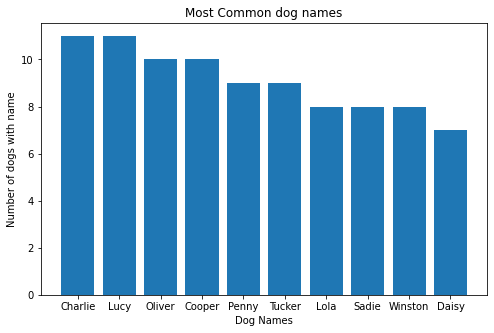

In [99]:
# Plotting graph to show most common dog names
common_names = []
count_of_names = []
for name, count in name_counter.most_common(10):
    common_names.append(name)
    count_of_names.append(count)
    

fig = plt.figure(figsize=(8,5))
plt.bar(common_names, count_of_names)
plt.title(label = 'Most Common dog names')
plt.ylabel('Number of dogs with name')
plt.xlabel('Dog Names')

#### It can be observed that Charlie and Lucy are the most common dog names in the archive followed by Oliver and Cooper